In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary

In [2]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('CPU')
print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Cleaning Data with opencv

In [4]:
import cv2
import imghdr

In [5]:
#os.listdir(os.path.join(data_dir,'browngraphs'))

In [6]:
data_dir = 'data'

In [7]:
image_extensions = ['jpeg','jpg','bmp','png']

In [8]:
for image_dirs in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_dirs)):
        image_path = os.path.join(data_dir, image_dirs, image)
        try:
            img = cv2.imread(image_path)
            ext = imghdr.what(image_path)
            if ext not in image_extensions:
                print('Image not in the extension list {}'.format(image_path))
                os.remove(image_path)
                
        except Exception as e:
            print("Issue with the image {}".format(image_path))
            #os.remove(image_path)

#removes images which are not openable by opencv and which are not in the extension list

Issue with the image data\browngraphs\.ipynb_checkpoints
Issue with the image data\normalgraphs\.ipynb_checkpoints


Load Data with keras in Tensorflow
Creates data pipelines which allows for bigger datasets which do not require as much memory

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')
#this function from keras takes the data from the directory data which contains the graphs of 
#brownian motion and resizes, scales, and preprocesses the data aswell, also labels the data

# SIMPLER: Builds data pipeline

Found 1324 files belonging to 2 classes.


In [15]:
data_runner = data.as_numpy_iterator()
#The data is loaded in the memory yet therefore you cannot get its first instance. This data is a
# a generator
# the numpy_iterator turns generator to a iterator and creates batches and .next
# loops through the data

#SIMPLER: Allows you to access the data pipeline

In [25]:
batch = data_runner.next()
# The batch returns a tuple of length 2, one part of the data is the actual images
# the second part of the data is the labels

# within the keras.utils.image_dataset_from_directory 
# you can change the amount of images per batch which is default 32


#SIMPLER: Accesses the data pipeline

In [26]:
batch[0].shape
#prints out the images represented as numpy arrays

(32, 256, 256, 3)

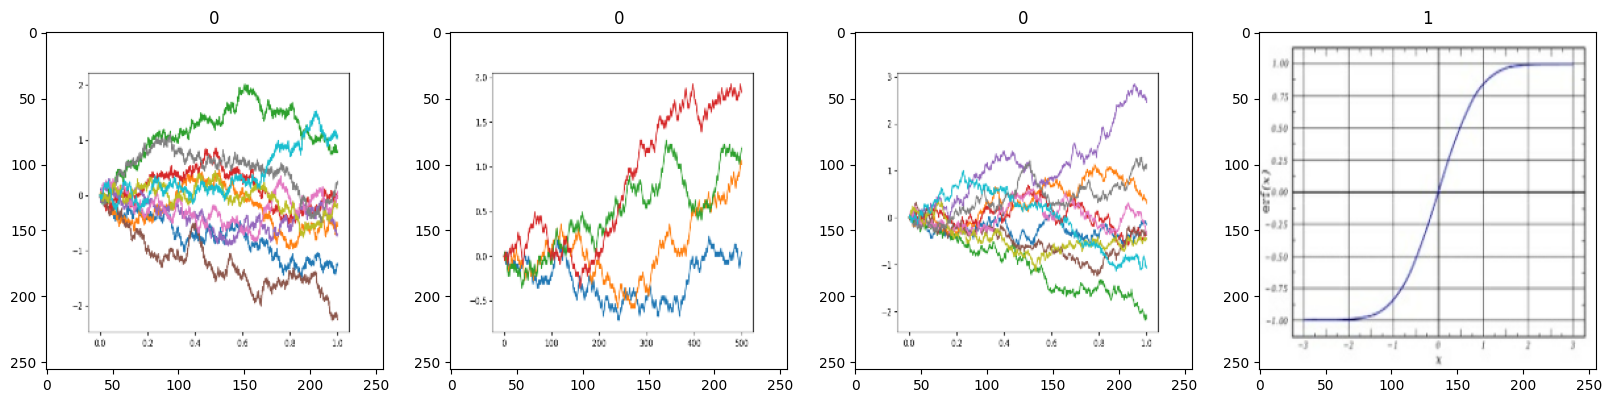

In [28]:
# Code: 0 is Brownian Motion
# Code: 1 is normal graphs
fig, ax = plt.subplots(ncols=4,figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
                          

Pre processing Data

Scale Data

In [11]:
data = data.map(lambda x, y: (x/255,y))
#changes all the images to holding values from 0 to 1 which greatly improves efficiency
# instead of changing the data each batch we change the data in the pipeline as it is being mapped

In [12]:
scaled_iterator = data.as_numpy_iterator()

In [13]:
batch = scaled_iterator.next()

In [14]:
batch[0].max()

1.0

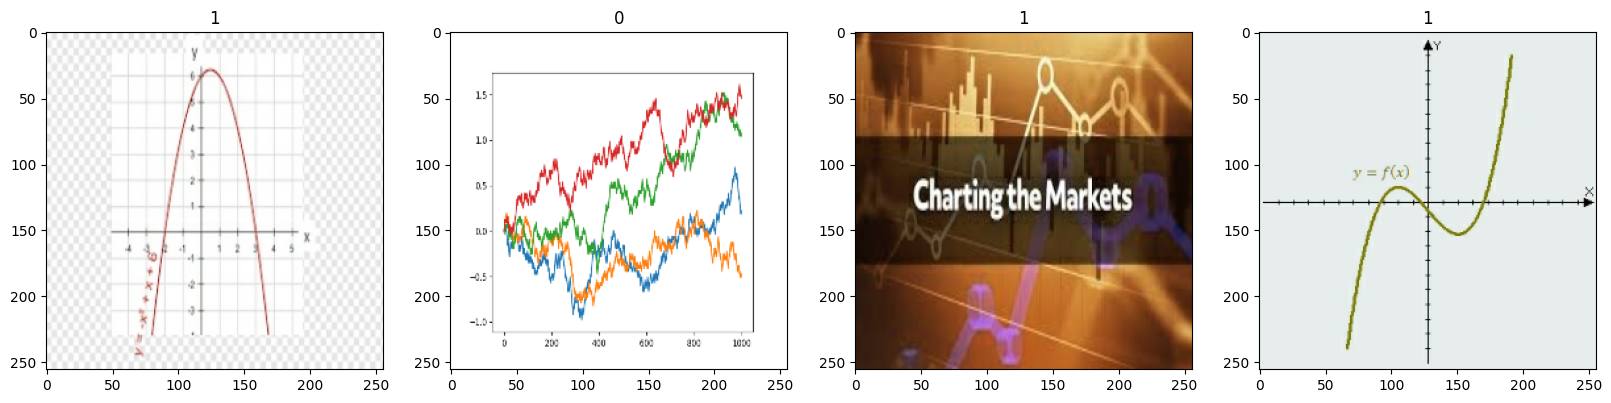

In [15]:
fig, ax = plt.subplots(ncols=4,figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [16]:
data.as_numpy_iterator().next()[0].max()

1.0

Spliting data 

In [17]:
len(data)

42

In [18]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1) + 1
#determining the number of batches of data that the model will receive for training, validating
# and testing

In [19]:
size = train_size + val_size + test_size
print(size)

42


In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [21]:
len(test)

5

The Deep Learning Model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

#To make a machine learning model you form a bunch of layers or hidden layers which 
# allow your AI to process the data and find similarties and differences

In [49]:
model = Sequential()

In [50]:
#The first layer is a convultion layer which takes a 256 by 256 input
# 16 filters each filter which scans image and extracts relevant information
# (3,3) each filter is 3x3 and a stride of 1 meaning it moves by 1 pixel each time
# relu activation takes the output from the layer to modify the output
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [51]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [52]:
weights = model.get_weights()


In [53]:
np.max(weights[1])


0.0

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

Training the Model

In [55]:
logdir='logs'

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [57]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
29/29 [==============================] - 25s 834ms/step - loss: 0.8206 - accuracy: 0.5970 - val_loss: 0.4914 - val_accuracy: 0.8203
Epoch 2/20
29/29 [==============================] - 23s 790ms/step - loss: 0.3772 - accuracy: 0.8772 - val_loss: 0.3388 - val_accuracy: 0.8711
Epoch 3/20
29/29 [==============================] - 24s 809ms/step - loss: 0.2781 - accuracy: 0.8987 - val_loss: 0.2689 - val_accuracy: 0.8828
Epoch 4/20
29/29 [==============================] - 24s 824ms/step - loss: 0.2158 - accuracy: 0.9159 - val_loss: 0.2219 - val_accuracy: 0.9023
Epoch 5/20
29/29 [==============================] - 23s 799ms/step - loss: 0.1944 - accuracy: 0.9332 - val_loss: 0.1893 - val_accuracy: 0.9141
Epoch 6/20
29/29 [==============================] - 22s 747ms/step - loss: 0.2219 - accuracy: 0.9192 - val_loss: 0.2781 - val_accuracy: 0.8984
Epoch 7/20
29/29 [==============================] - 23s 793ms/step - loss: 0.1657 - accuracy: 0.9386 - val_loss: 0.3257 - val_accuracy: 0.8906

Plot Performance

In [58]:
hist.history

{'loss': [0.8205771446228027,
  0.37719759345054626,
  0.27808326482772827,
  0.21582089364528656,
  0.19444039463996887,
  0.2218538224697113,
  0.16569623351097107,
  0.1364472210407257,
  0.09426897764205933,
  0.08108128607273102,
  0.09344527125358582,
  0.09994366019964218,
  0.0746137872338295,
  0.06521394103765488,
  0.02983381599187851,
  0.025378761813044548,
  0.016737638041377068,
  0.017817938700318336,
  0.043338753283023834,
  0.016665495932102203],
 'accuracy': [0.5969827771186829,
  0.8771551847457886,
  0.8987069129943848,
  0.9159482717514038,
  0.9331896305084229,
  0.9191810488700867,
  0.9385775923728943,
  0.9504310488700867,
  0.9655172228813171,
  0.9719827771186829,
  0.9709051847457886,
  0.962284505367279,
  0.9741379022598267,
  0.9806034564971924,
  0.9903017282485962,
  0.9913793206214905,
  0.993534505367279,
  0.9956896305084229,
  0.982758641242981,
  0.9946120977401733],
 'val_loss': [0.4914177358150482,
  0.3387635052204132,
  0.26888135075569153,
 

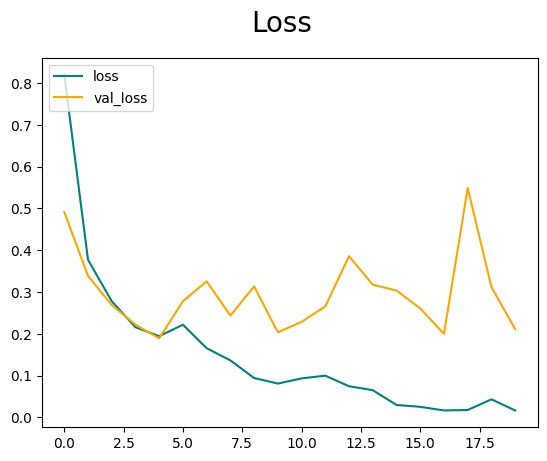

In [59]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

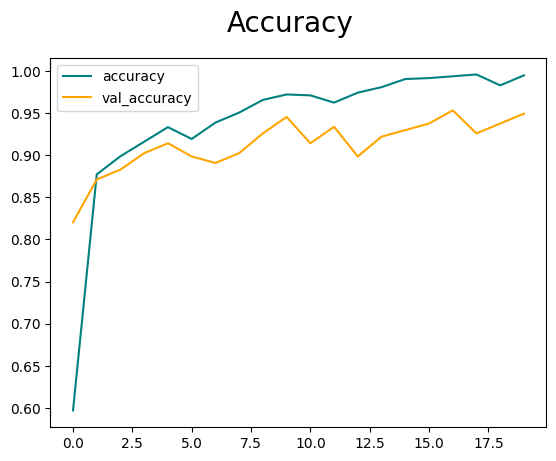

In [60]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

Testing Model

In [61]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [62]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [63]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 120ms/step


In [64]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9230769276618958, Recall:0.9729729890823364, Accuracy:0.9428571462631226


Test

In [65]:
import cv2


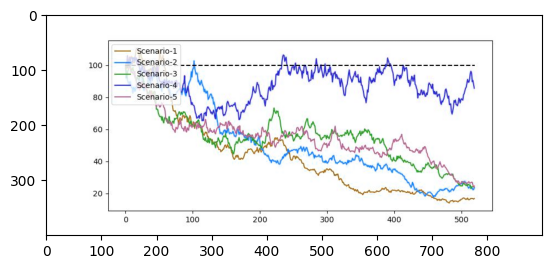

In [71]:
img = cv2.imread('browntest.jpg')
plt.imshow(img)
plt.show()

In [72]:
resize = tf.image.resize(img, (256,256))

In [73]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 26ms/step


In [74]:
yhat

array([[2.8315144e-11]], dtype=float32)

In [75]:
if yhat > 0.5: 
    print(f'Predicted class is a normal graph')
else:
    print(f'Predicted class is Brownian Motion Graph')

Predicted class is Brownian Motion Graph
